In [ ]:
import os
from readrec import *

sps = 10e6 # 10 Msps
path = "/home/kaklik/data_hroch/cosmic/Experiments/2019/07_21_blesky/cesky_les/P_Slavia/"
9
for fn in os.listdir(path)[:1]:
    with open(os.path.join(path, fn), 'rb') as f:
        try:
            h, samples, synclog = loadrec(f, skipsamples=True)
        except Exception as e:
            print(fn, e)
            continue

rec_190721-021621.24 Traceback (most recent call last):
  File "<ipython-input-6-3b54741f4a90>", line 81, in <module>
    plotrec(h, samples, synclog, title=fn, marktimes=triggers.index, pre_trigger_blocks=5, post_trigger_blocks=5)
  File "<ipython-input-6-3b54741f4a90>", line 46, in plotrec
    t2s, s2t, ticker, formatter = assign_time_axis(fn, h, synclog)
  File "/srv/envdeploy/shared_notebooks/readrec.py", line 92, in assign_time_axis
    synclog_pick = np.argmin(np.abs(synclog_rel))
  File "/srv/envdeploy/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py", line 1172, in argmin
    return _wrapfunc(a, 'argmin', axis=axis, out=out)
  File "/srv/envdeploy/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py", line 56, in _wrapfunc
    return getattr(obj, method)(*args, **kwds)
ValueError: attempt to get argmin of an empty sequence

2019-07-21 02:16:27.637841100 2019-07-21 02:16:27.703377100


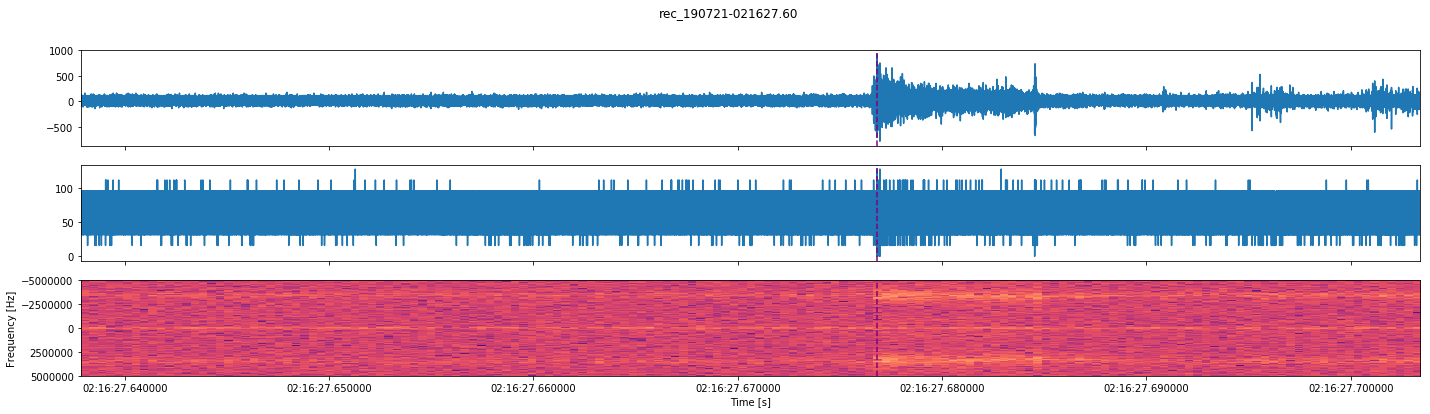

In [6]:
from matplotlib import pyplot as plt
import scipy.signal
import numpy as np
import math
import traceback

def waterfallize_pre(signal, bins):
    window = 0.5 * (1.0 - np.cos((2 * math.pi * np.arange(bins)) / bins))
    segment = int(bins / 2)
    nsegments = int(len(signal) / segment)
    m = np.repeat(np.reshape(signal[0:segment * nsegments], (nsegments, segment)), 2, axis=0)
    t = np.reshape(m[1:len(m) - 1], (nsegments - 1, bins))
    img = np.multiply(t, window)
    wf = np.fft.fft(img)
    return np.concatenate((wf[:, int(bins / 2):bins], wf[:, 0:int(bins / 2)]), axis=1)

def waterfallize(signal, bins):
    return np.log(np.abs(waterfallize_pre(signal, bins)))

def abs2(x):
    return x.real**2 + x.imag**2

def wf(samples, sample_rate, freq_offset=0, freq_lim=None, bins=8192, ax=None, title=None,
       offset=0):
    img = waterfallize(samples, bins).T
    img[np.isneginf(img)] = np.nan
    # ^^ might not be needed, was copied from pysdr-recviewer
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(24, 6))
    if title is not None:
        fig.suptitle(title)

    ax.imshow(img, extent=[offset, offset+len(samples), freq_offset + sample_rate/2, freq_offset - sample_rate/2],
             aspect='auto', interpolation='none', cmap='magma')
    ax.set_xlabel('Time [s]'); ax.set_ylabel('Frequency [Hz]');
    
    if freq_lim is not None:
        ax.set_ylim(freq_lim[0] + freq_offset, freq_lim[1] + freq_offset)

    return ax


def plotrec(h, samples, synclog, pre_trigger_blocks=10, post_trigger_blocks=5, title=None,
            marktimes=[]):
    t2s, s2t, ticker, formatter = assign_time_axis(fn, h, synclog)
    a = (h['preTrigger']-pre_trigger_blocks)*h['descSpan']//16 #select block of samples before trigger
    b = (h['preTrigger']+post_trigger_blocks)*h['descSpan']//16  #select blocks after trigger 
    
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(24, 6), nrows=3, sharex=True)
    if title is not None:
        fig.suptitle(title)
    ax1.xaxis.set_major_locator(ticker)
    ax1.xaxis.set_major_formatter(formatter)
    ax1.plot(range(a, b), samples[a:b,4])
    ax2.plot(range(a, b), samples[a:b,5])
    wf(samples[a:b,4] + 1j*samples[a:b,5], 10e6, bins=8192, ax=ax3, offset=a)
    
    at, bt = s2t(a), s2t(b)
    print(at, bt)
    for t in marktimes:
        if t > at and t < bt:
            for ax in [ax1, ax2, ax3]:
                ax.axvline(x=t2s(t), color='purple', ls='--')
    fig.show()
    #plt.show()


import datetime
def dateparse(time_in_secs):    
    return datetime.datetime.utcfromtimestamp(float(time_in_secs))
triggers = pd.read_csv(path + '/timemarks_filtered.csv', delimiter=',',
                       parse_dates=True, date_parser=dateparse, index_col='DateTime',
                       usecols = [0], names=['DateTime'], header=None, squeeze = True)
triggers = triggers.shift( periods = -18, freq = "S")

for fn in sorted(os.listdir(path))[:2]:
    with open(os.path.join(path, fn), 'rb') as f:
        try:
            h, samples, synclog = loadrec(f)
            plotrec(h, samples, synclog, title=fn, marktimes=triggers.index, pre_trigger_blocks=5, post_trigger_blocks=5)
        except:
            print(fn, traceback.format_exc())
            continue


In [3]:
sorted(os.listdir(path))

['rec_190721-021621.24',
 'rec_190721-021627.60',
 'rec_190721-021643.66',
 'rec_190721-021656.72',
 'rec_190721-021725.28',
 'rec_190721-021759.14',
 'rec_190721-021852.33',
 'rec_190721-021910.57',
 'rec_190721-021946.59',
 'rec_190721-022013.44',
 'rec_190721-022043.66',
 'rec_190721-022131.70',
 'rec_190721-022416.28',
 'rec_190721-022452.56',
 'rec_190721-022619.99',
 'rec_190721-022715.84',
 'rec_190721-023241.46',
 'rec_190721-023329.74',
 'rec_190721-023406.17',
 'rec_190721-023436.95',
 'rec_190721-040044.38',
 'rec_190721-040215.67',
 'rec_190721-040423.07',
 'rec_190721-040632.94',
 'rec_190721-040644.27',
 'rec_190721-040731.31',
 'rec_190721-042204.73',
 'rec_190721-043124.62',
 'timemarks.txt',
 'timemarks_filtered.csv']

In [5]:
triggers.index

DatetimeIndex(['2019-07-21 01:00:16.018319', '2019-07-21 01:00:39.739686',
               '2019-07-21 01:00:56.776487', '2019-07-21 01:01:10.571819',
               '2019-07-21 01:02:08.597584', '2019-07-21 01:03:15.396726',
               '2019-07-21 01:04:21.170192', '2019-07-21 01:05:29.901194',
               '2019-07-21 01:08:58.017881', '2019-07-21 01:12:25.349785',
               '2019-07-21 01:13:32.528416', '2019-07-21 01:14:35.865064',
               '2019-07-21 01:14:57.455134', '2019-07-21 01:16:52.828107',
               '2019-07-21 01:18:22.403264', '2019-07-21 01:19:04.627744',
               '2019-07-21 01:20:27.452709', '2019-07-21 01:26:02.860191',
               '2019-07-21 02:15:06.855876', '2019-07-21 02:15:26.632724',
               '2019-07-21 02:16:27.676827', '2019-07-21 02:16:43.736311',
               '2019-07-21 02:16:56.796638', '2019-07-21 02:17:25.364780',
               '2019-07-21 02:17:59.216299', '2019-07-21 02:18:52.411076',
               '2019-07-2